# Feature Engineering
They say that the 3 most important things to think about when buying are home are location, location, and location. The dataset provides a metric to that though, which is the actual location in terms of latitude and longitude. Utilizing this, we can introduce distance as an additional source of predictive power within the model. The main distances considered in this approach are the following:
<ul>
<li>Distance from city centers: housing prices may have price gradients from these commercial hubs, which are a valuable source of employment and income for many residents in King County. Prices may increase due to the proximity of economy.</li>
<li>Distance from airports, noise may a latent factor in housing prices. Home-seekers may be less tolerant of high-noise areas when buying a house.</li>
<li>Distance from certain freeways/busy roadways, as this affects both noise and commute.</li>
</ul>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import seaborn as sns

i5_df = pd.read_csv('king_county_i5.csv')

# i5 and City Distances and Durations
Approximately 900 samples of lat, long coordinates were taken along the i5 highway spanning King County using Google Maps. These points are then saved into a spreadsheet, and the Vincenty distance is calculated for each lat, long pair coresponding with a home in the data set against the sampled i5 coordinates.

GoogleMap's Distance API was utilized to attain the roadwise commute distances and durations between each home and three city centers: Seattle, Bellevue, and Redmond. The hypothesis is that the proximity to these expensive hubs may play a role in price gradients in housing prices -- as people may pay more to live in urban areas, or settle in the outskirts in areas considered suburban and more affordable.

Additionally, the GoogleMap's Distance API provides a temporal aspect: duration. Duration to these hubs define a sense of time spent in commute getting to important places within King County, which may be an amenity that a customer is considering when purchasing a home.

All samples derived from the i5 were rendered in unreadable formats utilizing a Degree/Minute/Second format rather than a decimal format. In order to utilize distance formulas, the i5 coordinates must be cleaned, parsed, and converted into the appropriate decimal equivalent.

## Cleaning of i5 Distance Data

In [16]:
lat_all = pd.DataFrame(
    {'lat':i5_df['lat'].str.split('"').str.get(0)})

lat_min_sec = pd.DataFrame(
    {'lat':lat_all['lat'].str.split("'").str.get(0)})
lat_seconds = {'lat':lat_all['lat'].str.split("'").str.get(1).astype(float)}

lat_degrees = pd.DataFrame(
    {'lat':lat_min_sec['lat'].str.split('�').str.get(0).astype(float)})
lat_minutes = {'lat':lat_min_sec['lat'].str.split("�").str.get(1).astype(float)}

In [7]:
lat_seconds['lat'] = lat_seconds['lat'] / 3600
lat_minutes['lat'] = lat_minutes['lat'] / 60

In [8]:
latitudes = lat_seconds['lat'] + lat_minutes['lat'] + lat_degrees['lat']
latitudes.describe()

count    972.000000
mean      47.520575
std        0.152816
min       47.257839
25%       47.392981
50%       47.523685
75%       47.647147
max       47.777508
Name: lat, dtype: float64

In [9]:
long_all = pd.DataFrame(
    {'long':i5_df['long'].str.split('"').str.get(0)})

long_min_sec = pd.DataFrame(
    {'long':long_all['long'].str.split("'").str.get(0)})
long_seconds = {'long':long_all['long'].str.split("'").str.get(1).astype(float)}

long_degrees = pd.DataFrame(
    {'long':long_min_sec['long'].str.split('�').str.get(0).astype(float)})
long_minutes = {'long':long_min_sec['long'].str.split("�").str.get(1).astype(float)}

In [10]:
long_seconds['long'] = long_seconds['long'] / 3600
long_minutes['long'] = long_minutes['long'] / 60

In [11]:
longitudes = -(long_seconds['long'] + long_minutes['long'] + long_degrees['long'])

In [12]:
longitudes.describe()

count    972.000000
mean    -122.306459
std        0.020198
min     -122.331256
25%     -122.323424
50%     -122.314664
75%     -122.291440
max     -122.263669
Name: long, dtype: float64

In [13]:
i5_dd = pd.DataFrame({'lat': latitudes, 'long': longitudes})

## Calculation of Property Distance from i5

In [14]:
from geopy.distance import vincenty
highway_dist = {}
i=0

for index, row in i5_dd.iterrows():
    highway_feature = []
    for index2, row_two in housing_data.iterrows():
        dist = vincenty((row['lat'], row['long']), (row_two['lat'], row_two['long'])).feet
        highway_feature.append(dist)
    highway_dist['hway_feat' + str(i)] = highway_feature
    i=i+1

In [4]:
hwy_dist_df = pd.DataFrame(highway_dist)
hwy_dist_df_tr = hwy_dist_df.transpose()hwy_dist_df.head()

housing_data['i5_dist'] = pd.DataFrame(hwy_dist_df_tr.min())
housing_data.head()
housing_data.to_csv('with_distance.csv')

In [19]:
i5_dist_data = pd.read_csv('with_distance.csv')
del i5_dist_data['Unnamed: 0']
i5_dist_data.to_csv('i5.csv', index=False)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-07-24 18:52:38.241793. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Performance Evaluation of New Features
XGBoost was utilized as a baseline regression model in analyzing the performance of these new features. The tree based method was selected due to the ease of use, and invariance to scales when introducing new distance and temporal values into the data set. 

Two primary sets were cultivated from the feature engineering process: distance and commute durations from city centers, and distance from 3 primary airports in King County.  n_estimators in the XGBoost regressors is the only hyperparameter that was actively tuned for optimization for each feature subset, in order to compare the predictive capabilities of the new features.

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
import xgboost as xgb

scaler = StandardScaler()
kc_i5_train, kc_i5_test, i5_train_Y, i5_test_Y = train_test_split(i5_dist_data, i5_dist_data['price'], test_size=.25, random_state=42)
kc_i5_train.drop('price', axis=1, inplace=True)
kc_i5_train.drop('date', axis=1, inplace=True)
kc_i5_train.drop('id', axis=1, inplace=True)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/json/encoder.py:199: DeprecationWarning: Interpreting naive datetime as local 2017-07-24 18:52:41.158574. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:
gbm_i5 = xgb.XGBRegressor(n_estimators=2000, seed=42)
kc_i5_train.dtypes
cv = cross_val_score(gbm_i5, kc_i5_train, i5_train_Y, cv=10, scoring='r2')

In [22]:
print(cv.mean())
# 0.904891375659

0.903703019504


In [ ]:
gbm_i5.fit(kc_i5_train, i5_train_Y)

In [ ]:
xgb.plot_importance(gbm_i5)

In [25]:
city = pd.read_csv('king_cc.csv')

In [26]:
city.head(n=5)

,distBellevue,distRedmond,distSeattle,durBellevue,durRedmond,durSeattle
0,28.5 km,41.5 km,21.5 km,26 mins,35 mins,23 mins
1,21.5 km,31.9 km,11.5 km,21 mins,26 mins,16 mins
2,20.9 km,15.1 km,33.7 km,22 mins,25 mins,31 mins
3,27.1 km,40.0 km,18.8 km,30 mins,39 mins,25 mins
4,22.5 km,10.2 km,35.2 km,25 mins,16 mins,34 mins


## Data Munging of Distance and Commute Values
The following code below describes the API call process to derive commute and roadwise distances from each property. API calls to GoogleMap's DistanceMatrix allows up to 2,500 free api calls per day, and an additional 0.50 cents per 1,000 api call. In total, making 66,000 api calls for 3 new features costed approximately 31 dollars.

In order to run the code below, uncomment the following code and convert from markdown to code, and register a googlemaps key to be inserted in the gmaps declaration..

import googlemaps
from datetime import datetime
gmaps = googlemaps.Client(#INSERTKEYHERE)

#Distance from Seattle,47.6475° N, 122.3497 W
#Distance from Bellevue 47.6101° N, 122.2015° W
#Distance from Redmond 47.6740° N, 122.1215° W


king_cc = {
    'Seattle': (47.6475, -122.3497),
    'Bellevue': (47.6101, -122.2015),
    'Redmond': (47.6740, -122.1215)
}


#testcase
#testdistSeattle = []
#durationtoSeattle = []
#for index, row in testFrame.iterrows():
#matrix = gmaps.distance_matrix((row['lat'], row['long']), king_cc['Seattle'])
#distancetoSeattle.append(matrix['rows'][0]['elements'][0]['distance']['text'])
#durationtoSeattle.append(matrix['rows'][0]['elements'][0]['duration']['text'])

distSeattle = []
durSeattle = []
distBellevue = []
durBellevue = []
distRedmond = []
durRedmond = []

for index, row in housing_data.iterrows():
    dmatSea = gmaps.distance_matrix((row['lat'], row['long']), king_cc['Seattle'])
    dmatBell = gmaps.distance_matrix((row['lat'], row['long']), king_cc['Bellevue'])
    dmatRed = gmaps.distance_matrix((row['lat'], row['long']), king_cc['Redmond'])
    distSeattle.append(dmatSea['rows'][0]['elements'][0]['distance']['text'])
    durSeattle.append(dmatSea['rows'][0]['elements'][0]['duration']['text'])
    distBellevue.append(dmatBell['rows'][0]['elements'][0]['distance']['text'])
    durBellevue.append(dmatBell['rows'][0]['elements'][0]['duration']['text'])
    distRedmond.append(dmatRed['rows'][0]['elements'][0]['distance']['text'])
    durRedmond.append(dmatRed['rows'][0]['elements'][0]['duration']['text'])


In [27]:
#conversion of time values
def calcDuration(di):
    l = []
    for d in di:
        l.append(d['hour'] * 60 + d['minute'])
    return l;

In [28]:
distBellevue = city['distBellevue'].str.split(' ').str.get(0).astype(float)
durBellevueList = city['durBellevue'].str.split(' ')

In [29]:
durBellevueList1 = []
for arr in durBellevueList:
    if (len(arr) == 2):
        durBellevueList1.append({'hour': 0, 'minute': float(arr[0])})
    else:
        durBellevueList1.append({'hour': float(arr[0]), 'minute': float(arr[2])})
        
durBellevue = calcDuration(durBellevueList1)

In [30]:
distSeattle = city['distSeattle'].str.split(' ').str.get(0).astype(float)
durSeattleList = city['durSeattle'].str.split(' ')

In [31]:
durSeattleList1 = []
for arr in durSeattleList:
    if (len(arr) == 2):
        durSeattleList1.append({'hour': 0, 'minute': float(arr[0])})
    else:
        durSeattleList1.append({'hour': float(arr[0]), 'minute': float(arr[2])})
        
durSeattle = calcDuration(durSeattleList1)

In [32]:
distRedmond = city['distRedmond'].str.split(' ').str.get(0).astype(float)
durRedmondList = city['durRedmond'].str.split(' ')
durRedmondList1 = []
for arr in durRedmondList:
    if (len(arr) == 2):
        durRedmondList1.append({'hour': 0, 'minute': float(arr[0])})
    else:
        durRedmondList1.append({'hour': float(arr[0]), 'minute': float(arr[2])})
        
durRedmond = calcDuration(durRedmondList1)

In [33]:
dist_dur_pd = pd.DataFrame(
    {'distSeattle': distSeattle,
     'durSeattle': durSeattle,
     'distBellevue': distBellevue,
     'durBellevue': durBellevue,
     'distRedmond': distRedmond,
     'durRedmond': durRedmond
    })

In [34]:
#append parsed data to the dataframe and save it to a csv
i5_dist_data['distSeattle'] = distSeattle
i5_dist_data['durSeattle'] = durSeattle
i5_dist_data['distBellevue'] = distBellevue
i5_dist_data['durBellevue'] = durBellevue
i5_dist_data['distRedmond'] = distRedmond
i5_dist_data['durRedmond'] = durRedmond

In [35]:
i5_dist_data.to_csv('i5_city.csv', index=False)

## XGBoost with City Distances and Commute Durations

In [36]:
scaler = StandardScaler()
kc_i5_train, kc_i5_test, i5_train_Y, i5_test_Y = train_test_split(i5_dist_data, i5_dist_data['price'], test_size=.25, random_state=42)
kc_i5_train.drop('price', axis=1, inplace=True)
kc_i5_train.drop('date', axis=1, inplace=True)
kc_i5_train.drop('id', axis=1, inplace=True)

In [37]:
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score
import xgboost as xgb

In [38]:
gbm_i5 = xgb.XGBRegressor(n_estimators=1900, seed=42)
kc_i5_train.dtypes
cv = cross_val_score(gbm_i5, kc_i5_train, i5_train_Y, cv=10, scoring='r2')

In [39]:
print(cv.mean())
# 0.905355585403

0.905286144536


The baseline model's R2 score was: 0.903524308219. Introducing the new distance and commute features increased the R2 score 0.905286144536, which is a 0.00176183631 increase.

In [40]:
gbm_i5.fit(kc_i5_train, i5_train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1900,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

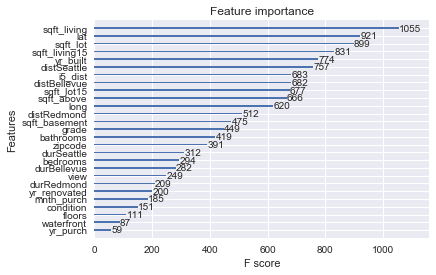

In [41]:
xgb.plot_importance(gbm_i5)

distSeattle, i5dist, and distBellevue seem to rank highly along the feature importance scale.

In [42]:
ap = pd.read_csv('kc_airports.csv')
del ap['Unnamed: 0']
ap.head(n=5)

,distBF,distRA,distSeaTac
0,12688.469538,11991.444291,26486.130761
1,70456.156047,86919.754992,101345.182916
2,78351.560666,89424.461864,108475.592537
3,22694.351785,44762.368937,36974.265724
4,71154.105069,61925.773807,88541.576510


## XGBoost with City Distances, City Commute Durations, and Airfield Distances

In [43]:
ci_i5_ap = i5_dist_data

In [44]:
ci_i5_ap['distBF'] = ap['distBF']
ci_i5_ap['distRA'] = ap['distRA']
ci_i5_ap['distSeaTac'] = ap['distSeaTac']

In [45]:
ci_i5_ap.head(n=5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,i5_dist,distSeattle,durSeattle,distBellevue,durBellevue,distRedmond,durRedmond,distBF,distRA,distSeaTac
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,5877.622101,21.5,23.0,28.5,26.0,41.5,35.0,12688.469538,11991.444291,26486.130761
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1312.366989,11.5,16.0,21.5,21.0,31.9,26.0,70456.156047,86919.754992,101345.182916
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,22578.916422,33.7,31.0,20.9,22.0,15.1,25.0,78351.560666,89424.461864,108475.592537
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,21931.464273,18.8,25.0,27.1,30.0,40.0,39.0,22694.351785,44762.368937,36974.265724
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,68342.455394,35.2,34.0,22.5,25.0,10.2,16.0,71154.105069,61925.773807,88541.576510


In [46]:
from sklearn.cross_validation import cross_val_score
import xgboost as xgb

scaler = StandardScaler()
ci_i5_ap_train, ci_i5_ap_test, ci_i5_ap_train_Y, ci_i5_ap_test_Y = train_test_split(ci_i5_ap, ci_i5_ap['price'], test_size=.25, random_state=42)
ci_i5_ap_train.drop('price', axis=1, inplace=True)
ci_i5_ap_train.drop('date', axis=1, inplace=True)
ci_i5_ap_train.drop('id', axis=1, inplace=True)

In [47]:
gbm_ci_i5_ap = xgb.XGBRegressor(n_estimators=1900, seed=42)
ci_i5_ap_train.dtypes
cv = cross_val_score(gbm_ci_i5_ap, ci_i5_ap_train, ci_i5_ap_train_Y, cv=10, scoring='r2')
print(cv.mean())

0.908226525736


0.908226525736 is an increase of 0.00470221751 from the baseline model, which was 0.903524308219.

In [48]:
gbm_ci_i5_ap.fit(ci_i5_ap_train, ci_i5_ap_train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1900,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

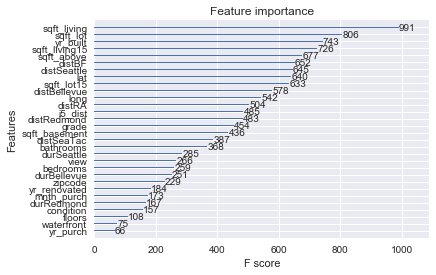

In [49]:
xgb.plot_importance(gbm_ci_i5_ap)

Distance to Boeing Field and distance to Seattle rank amongst the highest of the new features. The drastic increase in r2 score indicates that distance from airfield may encapsulate something that affects housing prices in the data set. Perhaps it is overall noise, or general neighborhood quality of these regions?

In [ ]:
ci_i5_ap.to_csv('ci_i5_ap.csv', index=False)

# EDA on New Features

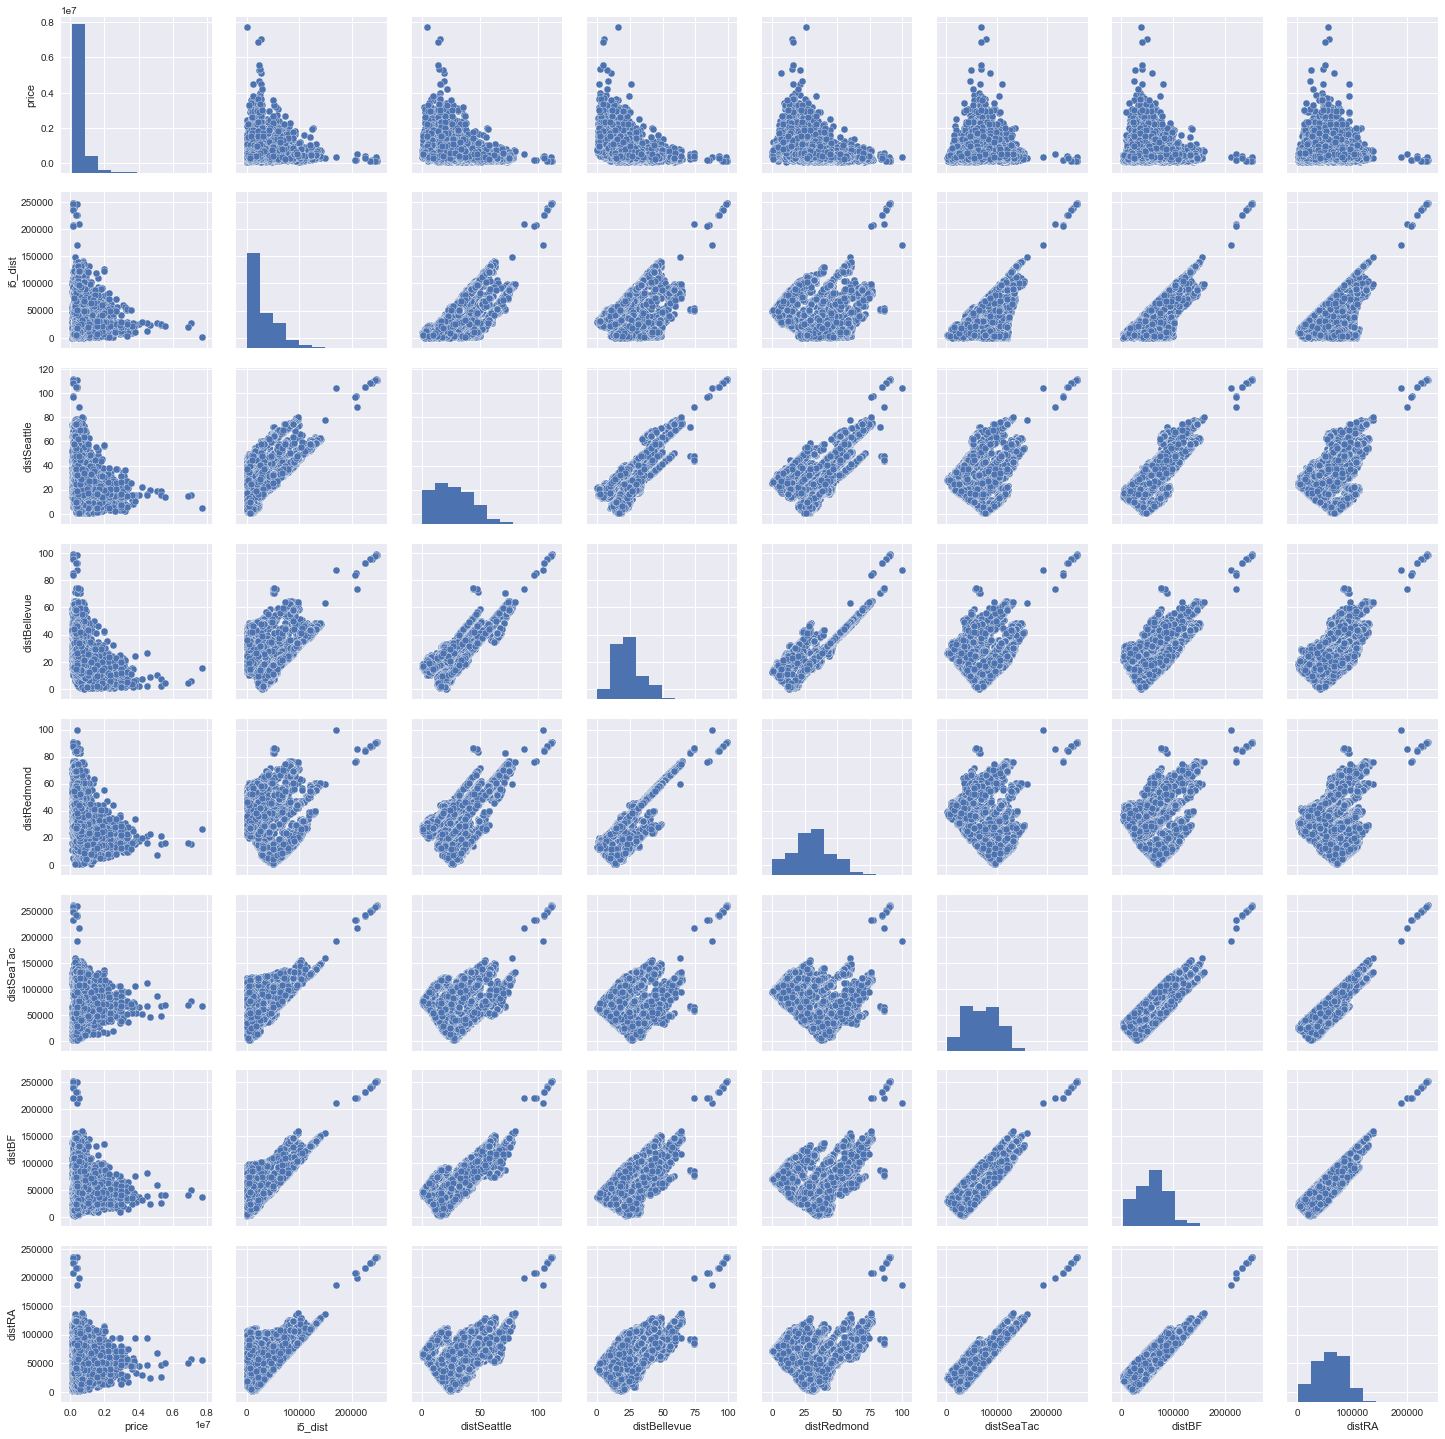

In [60]:
sns.pairplot(ci_i5_ap[['price', 'i5_dist', 'distSeattle', 'distBellevue', 'distRedmond', 'distSeaTac', 'distBF', 'distRA']])

While it is apparent that distances between city centers tend to exhibit some form of linearity, the more interesting narrative comes regarding price vs. distance. Analysis of distance from each city center with regards to price shows a larger variation of price ranges along the left, indicating that houses cost more the closer one is to the city. There seems to be a difference between the behaviour of price in terms of city center distances and airfield distances. 

Airfield distances do not exhibit the left-hugging behavior, rather, the high prices seem to occur at a later distance, which may indicate that there is a gradient of houses having low prices closer to an airport, which increases as these homes are positioned further away from airports.

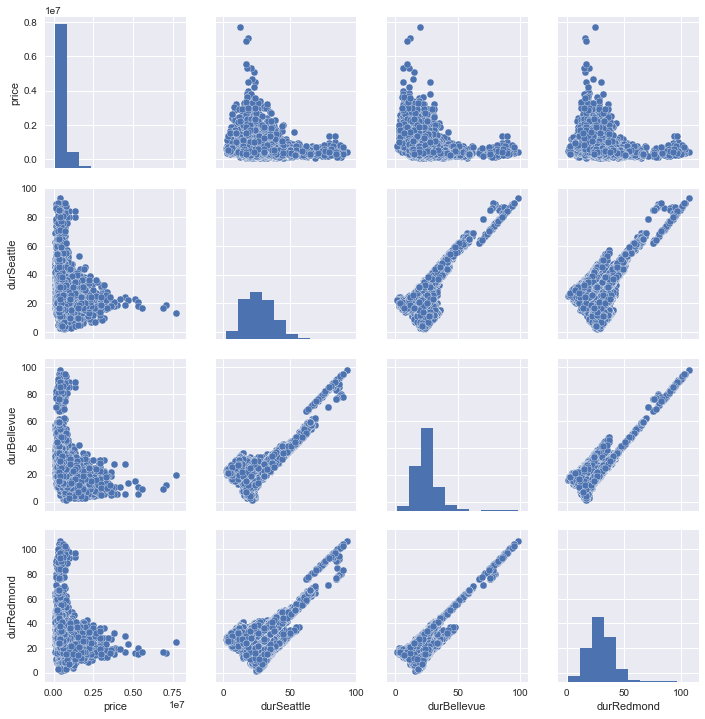

In [58]:
sns.pairplot(ci_i5_ap[['price', 'sqft_lot15', 'durSeattle', 'durBellevue', 'durRedmond']])

The same storyline follows for commute durations to these hubs. Higher variation in housing prices occur at distances that are relatively short, resulting in relative spikes at the left of the graph. This may support the initial hypothesis that it costs more to live closer to these economic hubs.

# Conclusion
This section exhibits feature engineering as an incredibly important aspect of the modeling process. Through the distance features that were gathered and constructed through sampling and domain knowledge of the region, the model is able to reap benefits its predictive capabilities (insert how much).

In total, 10 new features were added to the dataset.

<ul>
<li> i5_dist - shortest distance from i5 freeway in feet.
<li> distSeattle - roadwise distance from Seattle
<li> distRedmond - roadwise distance from Redmond
<li> distBellevue - roadwise distance from Bellevue
<li> durSeattle - commute duration to Seattle
<li> durRedmond - commute duration to Redmond 
<li> durBellevue - commute duration to Bellevue
<li> distSeaTac - shortest geodesic distance to SeaTac airport
<li> distBF - shortest geodesic distance to Boeing Field
<li> distRA - shortest geodesic distance to Renton Airfield

</ul>

However, there are alternative distance features that could be constructed. Distance to the coast may be another feature that encapsulates pricing behaviour, as houses with a waterfront tend to be more expensive than their inland counterparts. This would require the same sampling process used in the i5 sampling scheme to calculate the closest distance to a waterfront.

Additional distance features were limited by possible time and money constraints. Ideally, the same sampling method used on highways could be used to leverage distance to certain amenities such as parks, restaurants, and landmarks within the region, introducing the ability to compare the overall quality of neighborhoods between each house. This would be an extensive process of data gathering and feature engineering, and would likely require more time or the use of an analytics team.

DistBF ranks as the most important airport related distance feature, which may have encapsulated a signifcant pricing behaviour in consideration to houses near airports. Further statistical investigation is needed to determine the cause, and underlying factors.